# Метрики в задаче классификации

В этом ноутбуке мы рассмотрим такие метрики:
+ Accuracy
+ Precision, recall, F1
+ ROC-AUC
+ PR-AUC

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

Но сначала что-нибудь обучим

## Загрузка данных

In [2]:
# Считываем данные
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# Назначаем имена колонок, т.к. в файле их никак не назвали
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')
df.columns = columns.split()

df.head()

,age,workclass,fnlwgt,education,educ-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
# Целевая переменная - salary. Посмотрим на соотношение классов:
df.groupby('salary').count()[['age']]

,age
salary,
<=50K,24720
>50K,7841


In [5]:
# Превратим категориальные переменные в one-hot вектора

categorical_features = (
    'workclass education marital-status occupation relationship '
    'race sex native-country').split()

# categorical_features = 'workclass education'.split()

df_d = pd.get_dummies(df, columns=categorical_features, drop_first=True)

df_d.head()

,age,fnlwgt,educ-num,capital-gain,capital-loss,hours-per-week,salary,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,<=50K,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Посмотрим нулевую строку
df_d.iloc[0]

age                                   39
fnlwgt                             77516
educ-num                              13
capital-gain                        2174
capital-loss                           0
                                   ...  
native-country_ Thailand               0
native-country_ Trinadad&Tobago        0
native-country_ United-States          1
native-country_ Vietnam                0
native-country_ Yugoslavia             0
Name: 0, Length: 101, dtype: object

In [7]:
# Отделим целевую переменную
X = df_d.drop(['salary'], 1)
y = df_d['salary'] == ' >50K'

y.head()

0    False
1    False
2    False
3    False
4    False
Name: salary, dtype: bool

In [8]:
# Разобьем данные на тренировочную и тестовую части
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19536, 100) (13025, 100) (19536,) (13025,)


## Обучим модель

In [9]:
# Импортируем модель K Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)

# Сделаем предсказания
predictions_knn = model_knn.predict(X_test)
print(predictions_knn[:10])
predictions_knn.shape

[False False False False False False  True False False False]


(13025,)

In [10]:
# Еще возьмем модель покруче
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train, y_train)

# Сделаем предсказания
predictions_rf = model_rf.predict(X_test)
print(predictions_rf[:10])
predictions_rf.shape

[False False  True False False  True  True False False  True]


(13025,)

## 1. Accuracy


Теперь, когда у нас есть две модели, хорошо бы оценить их точность, чтобы понять, какая лучше.  

Здесь приходит на помощь метрика:

$$Accuracy = \frac{\sum_{x_i, y_i \in (X, Y)} I(y(x_i) = y_i)}{|(X, Y)|} = \frac{num~right~classified~obj}{num~all~obj}$$  

**Задание:** посчитайте accuracy наших предсказаний относительно `y_test`

In [11]:
# YOUR CODE HERE

# Ответ:

In [11]:
from sklearn.metrics import accuracy_score

# первый аргумент всегда y_test, а второй - предсказания
print('KNN accuracy:', accuracy_score(y_test, predictions_knn))
print('RF accuracy:', accuracy_score(y_test, predictions_rf))

KNN accuracy: 0.7773512476007678
RF accuracy: 0.8541266794625719


# Все хорошо, но есть один ньюанс...

In [12]:
from sklearn.dummy import DummyClassifier



In [13]:
model_dummy = DummyClassifier("most_frequent")
model_dummy.fit(X_train, y_train)

predictions_dummy = model_dummy.predict(X_test)

print('Dummy accuracy:', accuracy_score(y_test, predictions_dummy))

Dummy accuracy: 0.7596928982725528


/Users/alexandermarkov/anaconda3/envs/MADMO/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass strategy=most_frequent as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [15]:
model_dummy = DummyClassifier("stratified")
model_dummy.fit(X_train, y_train)

predictions_dummy = model_dummy.predict(X_test)

print('Dummy accuracy:', accuracy_score(y_test, predictions_dummy))

Dummy accuracy: 0.6361612284069098


/Users/alexandermarkov/anaconda3/envs/MADMO/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass strategy=stratified as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


**Вопрос:** почему такая большая accuracy у такой модели?  

**Вопрос:** значит ли это, что наши модели совсем ненамного лучше, чем ничего?

## 2. Precision, Recall, F1

Метрики, предназначенные для работы с несбалансированными классами.  
F1 вообще наиболее распространенная метрика для классификации.

### 2.1 Confusion matrix 
https://en.wikipedia.org/wiki/Confusion_matrix

Но сначала...

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predictions_rf)

array([[9156,  739],
       [1161, 1969]])

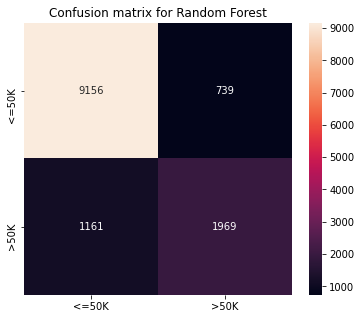

In [18]:
import seaborn as sns

fig = plt.figure(figsize=(6,5))

plt.title('Confusion matrix for Random Forest')
plt.ylabel("Real value", fontsize=14)
plt.xlabel("Predicted value", fontsize=14)

sns.heatmap(
    confusion_matrix(y_test, predictions_rf),
    annot=True, fmt="d",
    xticklabels=['<=50K', '>50K'], 
    yticklabels=['<=50K', '>50K']
);

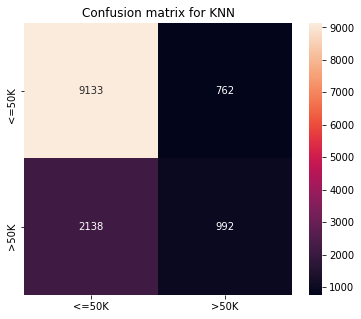

In [19]:
fig = plt.figure(figsize=(6,5))

plt.title('Confusion matrix for KNN')
plt.ylabel("Real value", fontsize=14)
plt.xlabel("Predicted value", fontsize=14)

sns.heatmap(
    confusion_matrix(y_test, predictions_knn),
    annot=True, fmt="d",
    xticklabels=['<=50K', '>50K'], 
    yticklabels=['<=50K', '>50K']
);

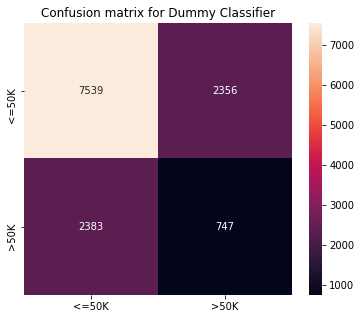

In [20]:
fig = plt.figure(figsize=(6,5))

plt.title('Confusion matrix for Dummy Classifier')
plt.ylabel("Real value", fontsize=14)
plt.xlabel("Predicted value", fontsize=14)

sns.heatmap(
    confusion_matrix(y_test, predictions_dummy),
    annot=True, fmt="d",
    xticklabels=['<=50K', '>50K'], 
    yticklabels=['<=50K', '>50K']
);

### Precision

## $$Precision = \frac{TP}{TP + FP}$$

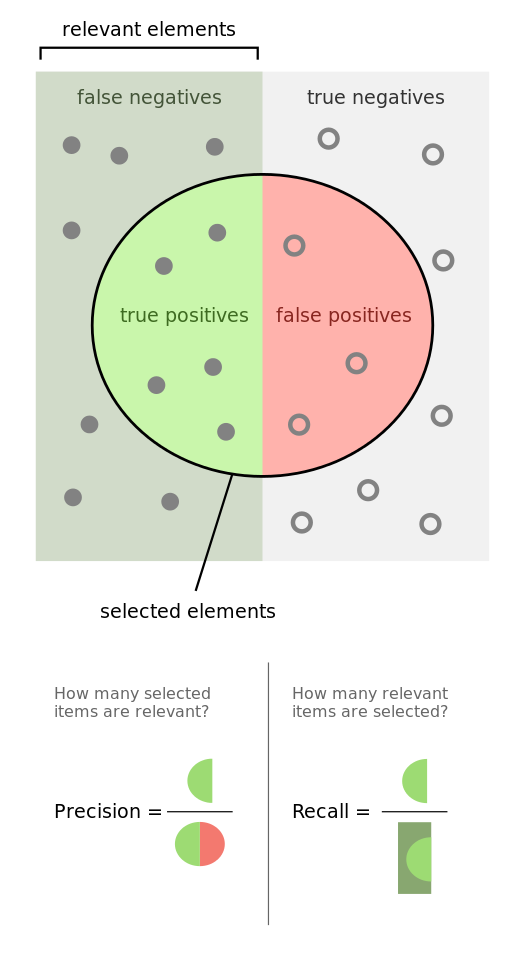

In [21]:
accuracy_score(y_test, predictions_dummy)

0.6361612284069098

In [23]:
from sklearn.metrics import precision_score, recall_score

print('KNN precision:', precision_score(y_test, predictions_knn))
print('RF precision:', precision_score(y_test, predictions_rf))
print('Dummy precision:', precision_score(y_test, predictions_dummy))

KNN precision: 0.5655644241733181
RF precision: 0.7271048744460856
Dummy precision: 0.24073477280051564


### Recall

## $$Recall = \frac{TP}{TP + FN}$$

In [24]:
from sklearn.metrics import recall_score, f1_score

print('KNN recall:', recall_score(y_test, predictions_knn))
print('RF recall:', recall_score(y_test, predictions_rf))
print('Dummy recall:', recall_score(y_test, predictions_dummy))

KNN recall: 0.3169329073482428
RF recall: 0.629073482428115
Dummy recall: 0.23865814696485624


Precision и Recall сами по себе не говорят о качестве модели. Нужно как-то их объединить.


### F1 score
## $$F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

Text(0, 0.5, 'Recall')

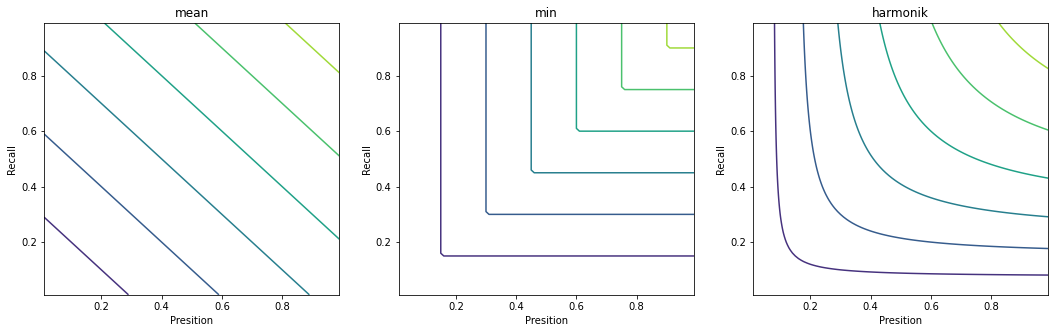

In [25]:
import scipy

fig, axs = plt.subplots(figsize=(18, 5), ncols=3)

x_, y_ = np.arange(0.01, 1, 0.01), np.arange(0.01, 1, 0.01)
X, Y = np.meshgrid(x_, y_)

Z = [[0.5*x + 0.5*y  for x in x_] for y in y_]
axs[0].contour(X, Y, Z)
axs[0].set_title('mean')
axs[0].set_xlabel('Presition')
axs[0].set_ylabel('Recall')

Z = [[min(x, y)  for x in x_] for y in y_]
axs[1].contour(X, Y, Z)
axs[1].set_title('min')
axs[1].set_xlabel('Presition')
axs[1].set_ylabel('Recall')


Z = [[scipy.stats.hmean([x, y])  for x in x_] for y in y_]
axs[2].contour(X, Y, Z)
axs[2].set_title('harmonik')
axs[2].set_xlabel('Presition')
axs[2].set_ylabel('Recall')

In [26]:
from sklearn.metrics import f1_score

print('KNN f1_score:', f1_score(y_test, predictions_knn))
print('RF f1_score:', f1_score(y_test, predictions_rf))
print('Dummy f1_score:', f1_score(y_test, predictions_dummy))

KNN f1_score: 0.4062244062244062
RF f1_score: 0.6745460774237751
Dummy f1_score: 0.2396919621370127


### Multiclass F1 score

In [29]:
from sklearn.metrics import classification_report

In [31]:
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

       False       0.89      0.93      0.91      9895
        True       0.73      0.63      0.67      3130

    accuracy                           0.85     13025
   macro avg       0.81      0.78      0.79     13025
weighted avg       0.85      0.85      0.85     13025



In [33]:
# Загрузим датасет с тремя классами

df_iris = sns.load_dataset("iris")
df_iris = df_iris.sample(n=150)
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
33,5.5,4.2,1.4,0.2,setosa
126,6.2,2.8,4.8,1.8,virginica
114,5.8,2.8,5.1,2.4,virginica
75,6.6,3.0,4.4,1.4,versicolor
140,6.7,3.1,5.6,2.4,virginica


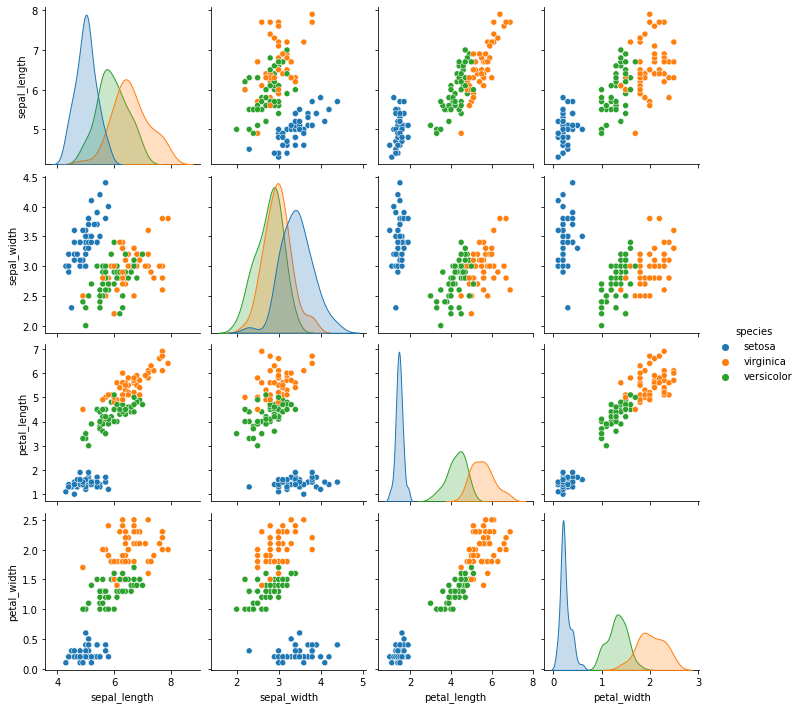

In [34]:
sns.pairplot(df_iris, hue="species");

In [35]:
# Разобьем на X, y
iris_X, iris_y = df_iris[df_iris.columns[:-1]].values, df_iris[df_iris.columns[-1]]
iris_y = iris_y.map({'virginica': 0, 'versicolor': 1, 'setosa': 2})

iris_X_train, iris_y_tain = iris_X[:30], iris_y[:30]
iris_X_test, iris_y_test = iris_X[40:], iris_y[40:]

In [36]:
# Обучим модели и сделаем предсказания
iris_clf_knn = KNeighborsClassifier().fit(iris_X_train, iris_y_tain)
iris_clf_mp = DummyClassifier("most_frequent").fit(iris_X_train, iris_y_tain)

iris_y_knn = iris_clf_knn.predict(iris_X_test)
iris_y_dummy = iris_clf_mp.predict(iris_X_test)

/Users/alexandermarkov/anaconda3/envs/MADMO/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass strategy=most_frequent as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


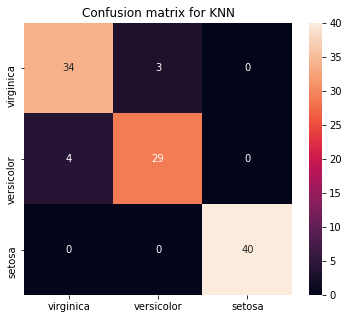

In [39]:
fig = plt.figure(figsize=(6,5))

plt.title('Confusion matrix for KNN')
plt.ylabel("Real value", fontsize=14)
plt.xlabel("Predicted value", fontsize=14)

sns.heatmap(
    confusion_matrix(iris_y_test, iris_y_knn),
    annot=True, fmt="d",
    xticklabels=['virginica', 'versicolor', 'setosa'], 
    yticklabels=['virginica', 'versicolor', 'setosa']
);

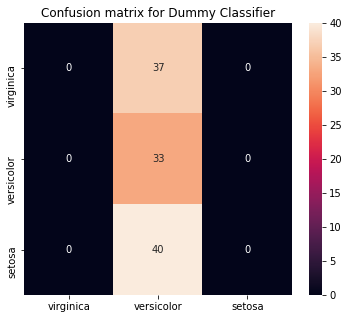

In [40]:
fig = plt.figure(figsize=(6,5))

plt.title('Confusion matrix for Dummy Classifier')
plt.ylabel("Real value", fontsize=14)
plt.xlabel("Predicted value", fontsize=14)

sns.heatmap(
    confusion_matrix(iris_y_test, iris_y_dummy),
    annot=True, fmt="d",
    xticklabels=['virginica', 'versicolor', 'setosa'], 
    yticklabels=['virginica', 'versicolor', 'setosa']
);

**Macro-averaging** -- подсчет TP, FN, TN, FP для каждого класса, а после подсчет точности и полноты.

**Micro-averaging** -- подсчет  точности и полноты для каждого класса, а после подсчет их среденего.

In [41]:
print('для kNN:')
print ('macro = ', f1_score(iris_y_test, iris_y_knn, average='macro'),
       ', micro = ', f1_score(iris_y_test, iris_y_knn, average='micro'))

# 
print('\nдля dummy-classifier:')
iris_y_knn[iris_y_knn==1] = 0
print ('macro = ', f1_score(iris_y_test, iris_y_knn, average='macro'),
       ', micro = ', f1_score(iris_y_test, iris_y_knn, average='micro'))

для kNN:
macro =  0.932991452991453 , micro =  0.9363636363636364

для dummy-classifier:
macro =  0.5638629283489097 , micro =  0.7


## ROC-AUC
*Receiver operating characteristic - area under curve*

Для этой метрики нам нужна модель, которая предсказывает не просто сами классы, а их вероятности.

Случайный лес и KNN так умеют:

In [45]:
predictions_rf_proba = model_rf.predict_proba(X_test)
predictions_knn_proba = model_knn.predict_proba(X_test)

predictions_rf = model_rf.predict(X_test)
predictions_rf_proba.shape, predictions_rf.shape

((13025, 2), (13025,))

In [46]:
predictions_rf[:3]

array([False, False,  True])

In [51]:
predictions_knn_proba[:5]

array([[1. , 0. ],
       [1. , 0. ],
       [0.8, 0.2],
       [0.8, 0.2],
       [1. , 0. ]])

In [47]:
predictions_rf_proba[:, 1]

array([[1.  , 0.  ],
       [0.57, 0.43],
       [0.44, 0.56]])

RF ROC AUC = 0.9026
KNN ROC AUC = 0.6576


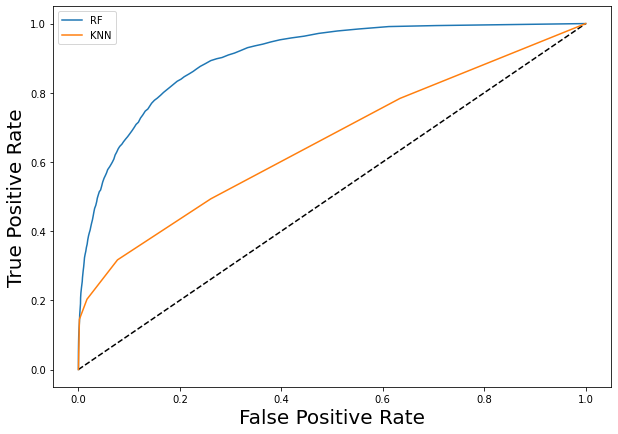

In [38]:
from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, thr = roc_curve(y_test, predictions_rf_proba[:,1])
fpr_knn, tpr_knn, _ = roc_curve(y_test, predictions_knn_proba[:,1])

plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_knn, tpr_knn, label='KNN')

plt.legend()
plt.xlabel("False Positive Rate", fontsize=20)
plt.ylabel("True Positive Rate", fontsize=20)

print ('RF ROC AUC = {0:.4f}'.format(auc(fpr_rf, tpr_rf)))
print ('KNN ROC AUC = {0:.4f}'.format(auc(fpr_knn, tpr_knn)))

## PR AUC

Random Forest PR AUC = 0.7659
K Neighbors PR AUC = 0.5047


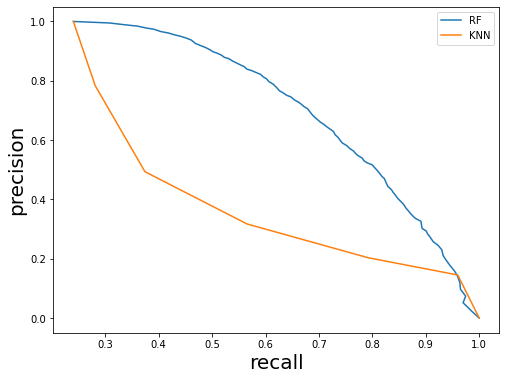

In [44]:
from sklearn.metrics import precision_recall_curve, auc

prec_rf, rec_rf, _ = precision_recall_curve(y_test, predictions_rf_proba[:,1])
prec_knn, rec_knn, _ = precision_recall_curve(y_test, predictions_knn_proba[:,1])

plt.figure(figsize=(8, 6))
plt.plot(prec_rf, rec_rf, label='RF')
plt.plot(prec_knn, rec_knn, label='KNN')

plt.legend()
plt.xlabel('recall', fontsize=20)
plt.ylabel('precision', fontsize=20)

print('Random Forest PR AUC = {0:.4f}'.format(auc(rec_rf, prec_rf)))
print('K Neighbors PR AUC = {0:.4f}'.format(auc(rec_knn, prec_knn)))

# Кросс-валидация

Допустим, мы выбрали метрику ROC-AUC для нашей задачи.

Задача, как и была:

In [40]:
X_train, X_test, y_train, y_test # это то, что у нас есть

X_train.head()

,age,fnlwgt,educ-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
25823,31,87418,11,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
10274,41,121718,10,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
27652,61,79827,9,0,0,50,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
13941,33,156015,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
31384,38,167882,10,0,0,45,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Модель - пока поиграем с KNN.

In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)

Как сделать кросс-валидацию?  
За нас уже все сделали:

In [42]:
from sklearn.model_selection import cross_validate

cv_result = cross_validate(knn, X_train, y_train, cv=5, scoring='roc_auc')
cv_result

{'fit_time': array([0.02405691, 0.02181816, 0.01739717, 0.01688004, 0.01708913]),
 'score_time': array([1.33056808, 1.41006279, 1.25273967, 1.24399114, 1.46492791]),
 'test_score': array([0.64139063, 0.63755742, 0.62745495, 0.65344662, 0.63728299])}

In [43]:
cv_result['test_score'].mean()

0.6394265207875495

Кросс-валидацию обычно используют для подбора гиперпараметров.  
У нас такой один - число соседей.

**Задание:** Подберите число соседей таким образом, чтобы кросс-валидация давала максимальный результат

# ответ

In [ ]:
from tqdm.notebook import tqdm

# Это можно использовать как начальное приближение
n_neighbors_grid = np.arange(1, 30, 6)

# Запишите сюда результаты, чтобы потом вывести их на график
results = []

for n_neighbors in tqdm(n_neighbors_grid):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    cv_result = cross_validate(knn, X_train, y_train, cv=5, scoring='roc_auc')
    results.append(max(cv_result['test_score']))
    # Your code here

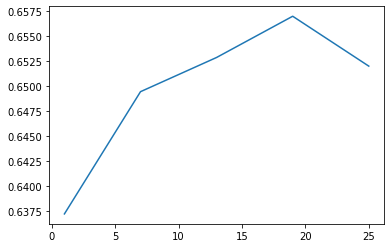

In [ ]:
plt.plot(n_neighbors_grid, results);

![meme](https://github.com/hocop/sberbank_madmo/raw/master/day_2/image_meme.png)